<a href="https://colab.research.google.com/github/cindyhfls/NMA_DL_2021_project/blob/main/runModelScriptAreaComparison_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import matplotlib, class functions, and set up variables.
from matplotlib import rcParams 
from matplotlib import pyplot as plt


import torch
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import default_collate


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
# Data Loading

#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

#@title Print Keys
print(alldat[0].keys())
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)
#@title Define Steinmetz Class
class SteinmetzSession:
  data = []
  binSize = 10
  nTrials = []
  nNeurons = []
  trialLen = 0
  trimStart = "trialStart"
  trimEnd =  "trialEnd"
  def __init__(self, dataIn):
    self.data = copy.deepcopy(dataIn)
    dims1 = np.shape(dataIn['spks'])
    self.nTrials = dims1[1]
    self.nNeurons = dims1[0]
    self.trialLen = dims1[2]

  def binData(self, binSizeIn): # Inputs: data, scalar for binning. Combines binSizeIn bins together to bin data smaller Ex. binSizeIn of 5 on the original dataset combines every 5 10 ms bins into one 50 ms bin across all trials.
    varsToRebinSum = ['spks']
    varsToRebinMean = ['wheel', 'pupil']
    spikes = self.data['spks']
    histVec = range(0,self.trialLen+1, binSizeIn)
    spikesBin = np.zeros((self.nNeurons, self.nTrials, len(histVec)))
    print(histVec)
    for trial in range(self.nTrials):
      spikes1 = np.squeeze(spikes[:,trial,:])
      for time1 in range(len(histVec)-1):
        spikesBin[:,trial, time1] = np.sum(spikes1[:, histVec[time1]:histVec[time1+1]-1], axis=1)

    spikesBin = spikesBin[:,:,:-1]
    self.data['spks'] = spikesBin
    self.trialLen = len(histVec) -1
    self.binSize = self.binSize*binSizeIn

    
    s = "Binned spikes, turning a " + repr(np.shape(spikes)) + " matrix into a " + repr(np.shape(spikesBin)) + " matrix"
    print(s)

  def plotTrial(self, trialNum): # Basic function to plot the firing rate during a single trial. Used for debugging trimming and binning
    plt.imshow(np.squeeze(self.data['spks'][:,trialNum,:]), cmap='gray_r', aspect = 'auto')
    plt.colorbar()
    plt.xlabel("Time (bins)")
    plt.ylabel("Neuron #")
    
  def realign_data_to_movement(self,length_time_in_ms): # input has to be n * nTrials * nbins
    align_time_in_bins = np.round(self.data['response_time']/self.binSize*1000)+ int(500/self.binSize) # has to add 0.5 s because the first 0.5 s is pre-stimulus
    length_time_in_bins = int(length_time_in_ms/self.binSize)
    validtrials = self.data['response']!=0
    maxtime = self.trialLen
    newshape = (self.nNeurons,self.nTrials)
    newshape+=(length_time_in_bins,)
    newdata = np.empty(newshape)
    for count,align_time_curr_trial in enumerate(align_time_in_bins):
      if (validtrials[count]==0)|(align_time_curr_trial+length_time_in_bins>maxtime) :
        validtrials[count] = 0
      else:
        newdata[:,count,:]= self.data['spks'][:,count,int(align_time_curr_trial):int(align_time_curr_trial)+length_time_in_bins]
    # newdata = newdata[:,validtrials,:]
    self.data['spks'] = newdata
    # self.validtrials = validtrials
    print('spikes aligned to movement, returning validtrials')
    return validtrials
  
  def get_areas(self):
    print(set(list(self.data['brain_area'])))

  def extractROI(self, region): #### extract neurons from single region
    rmrt=list(np.where(self.data['brain_area']!=region))[0]
    print(f' removing data from {len(rmrt)} neurons not contained in {region} ')
    self.data['spks']=np.delete(self.data['spks'],rmrt,axis=0)
    neur=len(self.data['spks'])
    print(f'neurons remaining in trial {neur}')
    self.data['brain_area']=np.delete(self.data['brain_area'],rmrt,axis=0)
    self.data['ccf']=np.delete(self.data['ccf'],rmrt,axis=0)
    
  def FlattenTs(self):
    self.data['spks']=np.hstack(self.data['spks'][:])

  def removeTrialAvgFR(self):
    mFR = self.data['spks'].mean(1)
    mFR = np.expand_dims(mFR, 1)
    print(np.shape(self.data['spks']))
    print(np.shape(mFR))
    self.data['spks'] = self.data['spks'].astype(float)
    self.data['spks'] -= mFR

  def sqrt_norm(self):
    self.data['spks'] = np.sqrt(self.data['spks'])  
  
  def permdims(self):
    return torch.permute(torch.tensor(self.data['spks']),(2,1,0))

  def smoothFR(self, smoothingWidth):# TODO: Smooth the data and save it back to the data structure
    return 0

#@title get input for network from session 31
s31=SteinmetzSession(alldat[30])
s31.sqrt_norm()
s31.removeTrialAvgFR()
validtrials = s31.realign_data_to_movement(500) # get 500 ms from movement time, 
# cannot get realign and binning to work the same time =[

# Model
class Net(nn.Module): # our model
  def __init__(self, ncomp, NN1, NN2, bidi=True, dropout = 0):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn1 = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0, # MO
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.rnn2 = nn.RNN(NN2,ncomp,num_layers = 1, dropout = 0, bidirectional = bidi, nonlinearity = 'tanh') #TH

    if bidi == True:
      self.fclatent = nn.Linear(ncomp*2,ncomp*2)
    else: 
      self.fclatent = nn.Linear(ncomp,ncomp)

    self.fc = nn.Linear(ncomp,NN1)

  def forward(self, x0,x1):
    y2 = self.rnn2(x0)[0] # ncomp TH
    y =  self.rnn1(x1)[0] # ncomp MOs
    y = y + self.fclatent(y2) # ncomp MOs with projection of latent TH components

    if self.rnn1.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

def pearson_corr_tensor(input, output):
  rpred = output.detach().cpu().numpy()
  rreal = input.detach().cpu().numpy()
  rpred_flat = np.ndarray.flatten(rpred)
  rreal_flat = np.ndarray.flatten(rreal)
  corrcoeff = np.corrcoef(rpred_flat, rreal_flat)
  return corrcoeff[0,1]

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
(977, 237, 250)
(977, 1, 250)
spikes aligned to movement, returning validtrials


In [ ]:
def runAreaModels(s31, lr, firstArea, secondArea, latentSize, nIter, validtrials, dropout, bidi, plotExamples = False, verboseFlag = False):
  ### print areas
  s31.get_areas()

  # s31.FlattenTs()
  nTr = np.argwhere(validtrials) # since the other trials were defaulted to a zero value, only plot the valid trials

  MO = copy.deepcopy(s31)
  ###remove all neurons not in motor cortex
  MO.extractROI(firstArea)

  ### plot a trial from motor neuron
  if plotExamples:
    plt.figure()
    MO.plotTrial(nTr[1])
    plt.title(firstArea)

  ### permute the trials
  MOdata = MO.permdims().float().to(device)
  MOdata = MOdata[:,validtrials,:]
  print(MOdata.shape)

  TH = copy.deepcopy(s31)
  ###remove all neurons not in motor cortex
  TH.extractROI(secondArea)
  ### plot a trial from motor neuron
  if plotExamples:
    plt.figure()
    TH.plotTrial(nTr[1])
    plt.title(secondArea)

  THdata = TH.permdims().float().to(device)
  THdata = THdata[:,validtrials,:]

  NN1 = MOdata.shape[2]
  NN2 = THdata.shape[2]

  N = MOdata.shape[1]
  np.random.seed(42)
  ii = torch.randperm(N).tolist()
  idx_train = ii[:math.floor(0.6*N)]
  idx_val = ii[math.floor(0.6*N):math.floor(0.9*N)]
  idx_test = ii[math.floor(0.9*N):]

  x0_train = THdata[:,idx_train,:]
  x0_val = THdata[:,idx_val,:]
  x0_test = THdata[:,idx_test,:]

  x1_train = MOdata[:,idx_train,:]
  x1_val = MOdata[:,idx_val,:]
  x1_test = MOdata[:,idx_test,:]
  ncomp = latentSize

  learning_rate_start = lr
  net_baseline = Net(ncomp, NN1, NN2, bidi = bidi, dropout= dropout).to(device)
  net_baseline.fclatent.weight.data[:] = 0 # fixed weights =0 so the TH input is not considered
  net_baseline.fclatent.bias.data[:] = 0
  net_baseline.fclatent.weight.requires_grad = False
  net_baseline.fclatent.bias.requires_grad = False

  # special thing:  we initialize the biases of the last layer in the neural network
  # we set them as the mean firing rates of the neurons.
  # this should make the initial predictions close to the mean, because the latents don't contribute much
  # net_baseline.fc.bias.data[:] = MOdata.mean((0,1))

  # we set up the optimizer later in the training loop
  if verboseFlag:
    print(net_baseline)

  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(net_baseline.parameters(), lr=learning_rate_start)

  training_cost = []
  val_cost = []
  for k in range(nIter):
    ### training
    optimizer.zero_grad()
    # the network outputs the single-neuron prediction and the latents
    z, y = net_baseline(x0_train,x1_train)
    cost = loss(z,x1_train).mean()
    # # our log-likelihood cost
    # cost = Poisson_loss(z, x1_train).mean()
    # train the network as usual
    cost.backward()
    optimizer.step()
    training_cost.append(cost.item())

    ### test on validation data
    z_val,_ = net_baseline(x0_val,x1_val)
    cost = loss(z_val,x1_val).mean()
    # cost = Poisson_loss(z_val, x1_val).mean()
    val_cost.append(cost.item())

    if k % 100 == 0:
      if verboseFlag:
        print(f'iteration {k}, cost {cost.item():.4f}')

  if plotExamples:
    plt.plot(training_cost,'b')
    plt.plot(val_cost,'r')
    plt.hlines(np.min(training_cost),0,nIter,'b',linestyles = '--')
    plt.hlines(np.min(val_cost),0,nIter,'r',linestyles = '--')

    plt.legend(['training cost','validation cost','min training cost','min validation cost'])
    plt.title('Training cost over epochs')
    plt.ylabel('cost')
    plt.xlabel('epochs')

  corr = pearson_corr_tensor(x1_val, z_val)

  rpred = z.detach().cpu().numpy()
  rates = x1_train.cpu()

  if plotExamples:
    nTr = 5
    nNeuron = 0
    plt.figure(figsize=(10, 6))
    plt.plot(rates[:,nTr, nNeuron])
    plt.plot(rpred[:,nTr, nNeuron])

    plt.legend(['spikes', 'rates (predicted)'])
    plt.title(f'training set Trial {nTr}, Neuron {nNeuron}')
    plt.show()

    plt.figure(figsize = (12, 8))
    plt.subplot(121)
    plt.imshow(rates[:, nTr, :].T, cmap='gray_r')
    plt.xlabel('Time (ms)')
    plt.ylabel('Cell #')
    plt.title(f'True rates (training set trial {nTr})')

    plt.subplot(122)
    plt.imshow(rpred[:, nTr, :].T, cmap='gray_r')
    plt.xlabel('Time (ms)')
    plt.ylabel('Cell #')
    plt.title(f'Inferred rates (training set trial {nTr})')
    plt.show()

  PATH = 'steinmetz_model_baseline.pt'
  torch.save(net_baseline.state_dict(), PATH) 
  del net_baseline

  # load saved model
  net_baseline = Net(ncomp, NN1, NN2, bidi = bidi, dropout= dropout).to(device)
  net_baseline.load_state_dict(torch.load('steinmetz_model_baseline.pt'))

  # after training the baseline network, get the weights of rnn1 and freeze it
  net_withinput  = copy.deepcopy(net_baseline)

  net_withinput.fclatent.weight.requires_grad = True
  net_withinput.fclatent.bias.requires_grad = True

  # # set weight initalization to random
  net_withinput.fclatent.reset_parameters()


  net_withinput.rnn1.weight_ih_l0.requires_grad = False
  net_withinput.rnn1.weight_hh_l0.requires_grad = False
  net_withinput.rnn1.bias_ih_l0.requires_grad = False
  net_withinput.rnn1.bias_hh_l0.requires_grad = False
  if bidi:
    net_withinput.rnn1.weight_ih_l0_reverse.requires_grad = False
    net_withinput.rnn1.weight_hh_l0_reverse.requires_grad = False
    net_withinput.rnn1.bias_ih_l0_reverse.requires_grad = False
    net_withinput.rnn1.bias_hh_l0_reverse.requires_grad = False
  
  if verboseFlag:
    print(net_withinput)


  # we define the Poisson log-likelihood loss
  # def Poisson_loss(lam, spk):
  #   return lam - spk * torch.log(lam)
  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(net_withinput.parameters(), lr=learning_rate_start) # this is very important



  training_cost2 = []
  val_cost2 = []
  for k in range(nIter):
    ### training
    optimizer.zero_grad()
    # the network outputs the single-neuron prediction and the latents
    z, y = net_withinput(x0_train,x1_train)
    # our log-likelihood cost
    cost = loss(z, x1_train).mean()
    # train the network as usual
    cost.backward()
    optimizer.step()
    training_cost2.append(cost.item())

    ### test on validation data
    z_val,_ = net_withinput(x0_val,x1_val)
    cost = loss(z_val, x1_val).mean()
    val_cost2.append(cost.item())
    if k % 100 == 0:
      if verboseFlag:
        print(f'iteration {k}, cost {cost.item():.4f}')

  corr2 = pearson_corr_tensor(x1_val, z_val)

  return training_cost, training_cost2, val_cost, val_cost2, corr, corr2

Bootstrap num  {0}  of  {10}
{'ORB', 'OLF', 'TH', 'SCm', 'MOs', 'CA3', 'POST', 'SNr'}
 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data from 868 neurons not contained in TH 
neurons remaining in trial 109


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


{'ORB', 'OLF', 'TH', 'SCm', 'MOs', 'CA3', 'POST', 'SNr'}
 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data from 899 neurons not contained in OLF 
neurons remaining in trial 78
Bootstrap num  {1}  of  {10}
{'ORB', 'OLF', 'TH', 'SCm', 'MOs', 'CA3', 'POST', 'SNr'}
 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data from 868 neurons not contained in TH 
neurons remaining in trial 109
{'ORB', 'OLF', 'TH', 'SCm', 'MOs', 'CA3', 'POST', 'SNr'}
 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data from 899 neurons not contained in OLF 
neurons remaining in trial 78
Bootstrap num  {2}  of  {10}
{'ORB', 'OLF', 'TH', 'SCm', 'MOs', 'CA3', 'POST', 'SNr'}
 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data

ValueError: ignored

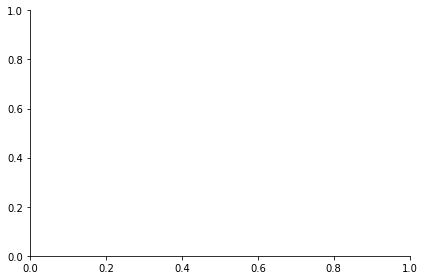

In [ ]:
numSplits = 2
doVec = np.linspace(0, 0.9, numSplits)
bootstraps = 10
nIter = 1000
train_cost = np.zeros((numSplits, nIter, bootstraps))
train_cost2 = np.zeros((numSplits, nIter, bootstraps))
val_cost = np.zeros((numSplits, nIter, bootstraps))
val_cost2 = np.zeros((numSplits, nIter, bootstraps))
corr = np.zeros((numSplits, nIter, bootstraps))
corr2 = np.zeros((numSplits, nIter, bootstraps))

firstArea = 'MOs'
secondArea = 'TH'
thirdArea = 'OLF'

latentSize = 3
nIter = 1000
dropout = .5
bidi = False
lr = 0.002


for boot in range(bootstraps):
  print(f'Bootstrap num ',{boot}, ' of ', {bootstraps})
  train_cost[0,:, boot], train_cost2[0,:, boot], val_cost[0,:, boot], val_cost2[0,:, boot], corr[0,:, boot], corr2[0,:, boot] = runAreaModels(s31, lr, firstArea, secondArea, latentSize, nIter, validtrials, dropout, bidi, verboseFlag = False)
  train_cost[1,:, boot], train_cost2[1,:, boot], val_cost[1,:, boot], val_cost2[1,:, boot], corr[1,:, boot], corr2[1,:, boot] = runAreaModels(s31, lr, firstArea, thirdArea, latentSize, nIter, validtrials, dropout, bidi, verboseFlag = False)

# plt.figure()

# plt.plot(val_cost-1)
# plt.plot(val_cost2-1)

(20000,)
(20000,)


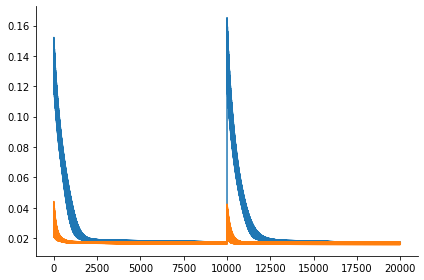

In [ ]:
val_cost = val_cost.reshape(-1,)
val_cost2 = val_cost2.reshape(-1,)
print(np.shape(val_cost))
print(np.shape(val_cost2))
plt.figure()

plt.plot(val_cost)
plt.plot(val_cost2)